# S-I-R Infection Spread Model

For the models overview, please see:
 * https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model

In the following models,

* S stands for: Number of people at risk to catch the disease
* I means:  Having the disease
* and R is for Removed, i.e. imune to disease, e.g. from the beginning or after the cure
* D - number of days beging infectious
* $R_0$ - basic reproduction number

$N=S+I+R$

$\frac{dS}{dt}=-\beta \frac{I}{N} S $

$\frac{dI}{dt}=\beta \frac{I}{N} S-\gamma I$

$\frac{dR}{dt}=\gamma I$

$\gamma = \frac{1}{D}$

$R_0 = \frac{\beta}{\gamma}$

In [323]:
import numpy as np
import pandas as pd
from scipy import stats as sps
from scipy.interpolate import interp1d


def model_SIR_with_vaccination(
    Rmin = 1.2,
    Rmax = 1.75,
    gamma=1.0/7.0,
    population = 10000000, 
    days_to_project=500, 
    V_percentage = 17.5,
    vaccination_start=0.25,
    R_samples = [],
    vaccination_end=0.5):
    
    N = population
    I = 3
    R = 0
    V = 0
    S = N - I - R - V
    C = 0

    Infected = []
    Suspectible = []
    Removed = []
    Vaccinated = []
    Cumulative = []

    if R_samples is None or len(R_samples)==0:
        R_samples = np.random.uniform(Rmin, Rmax, days_to_project)
    V_people = N * V_percentage/100.0
   

    vac_start_day=int(vaccination_start*days_to_project)
    vac_remaining_days=int((1-vaccination_end)*days_to_project)
    vac_period = days_to_project - vac_start_day - vac_remaining_days

    V_people_a_day = V_people/vac_period

    Vaccination_samples = np.concatenate((
         np.zeros(vac_start_day),
         np.random.uniform(0.5*V_people_a_day, 1.5*V_people_a_day, vac_period),
         np.zeros(vac_remaining_days),
     ))
    for day in range(days_to_project):
        Rt = R_samples[day]
        
        beta = Rt  * gamma
    
        intI = int(I)
        intS = int(S)
        intR = int(R)
        intV = int(V)
        intC = int(C)

        Infected.append(intI)
        Suspectible.append(intS)
        Removed.append(intR)
        Vaccinated.append(intV)
        Cumulative.append(intC)
    
        dV = Vaccination_samples[day]
        dS = -beta * I * S/N - dV
        dI = beta*I*S/N - gamma*I
        dR = gamma*I

        S += dS
        I += dI
        R += dR
        V += dV
        C += -dS

    df = pd.DataFrame(data={'Cumulative':Cumulative, 'Infected': Infected, 'Suspectible':Suspectible, 'Removed': Removed, 'Rt': R_samples, 'Vaccinated':Vaccinated})
    df['Total'] = df['Infected'] + df['Suspectible'] + df['Removed'] + df['Vaccinated']
    df['Daily Cases'] = df['Cumulative'] - df['Cumulative'].shift(periods=1, fill_value=0)
    return df

#df = model_SIR_with_vaccination()
#df.tail(5)


In [324]:

import matplotlib.pyplot as plt
import seaborn as sns

def cplot(fig, ax, df, column_str, title, bars=False, color=None):
    #fig, ax = plt.subplots(figsize=(12, 12))
    clms = []
    if not isinstance(column_str, list):
        clms = [column_str]
    else:
        clms = column_str
        
    if bars:
        for c in clms:
            ax.bar(
                df.index.values,
                df[c],
                color=color
            )
    else:
        for c in clms:
            ax.plot(df.index.values,
               df[c],
               marker='o',
               color=color)

# Set title and labels for axes
    ax.legend(clms)
    ax.set(xlabel="Datum",
       ylabel=column_str,
       title=title)
    #plt.show()


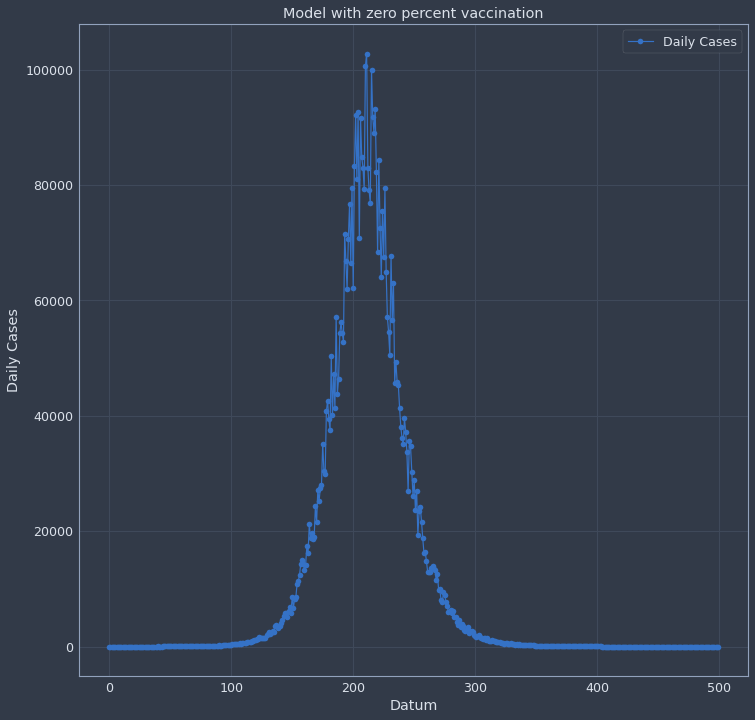

In [328]:
fig, ax = plt.subplots(figsize=(12, 12))
cplot(
    fig, ax, 
    model_SIR_with_vaccination(V_percentage=0),
#    ['Infected', 'Suspectible', 'Removed', 'Vaccinated'],
 #   ['Cumulative', 'Infected', 'Daily Cases'],
#    'Infected',
    'Daily Cases',
    "Model with zero percent vaccination", bars=False)
plt.show()

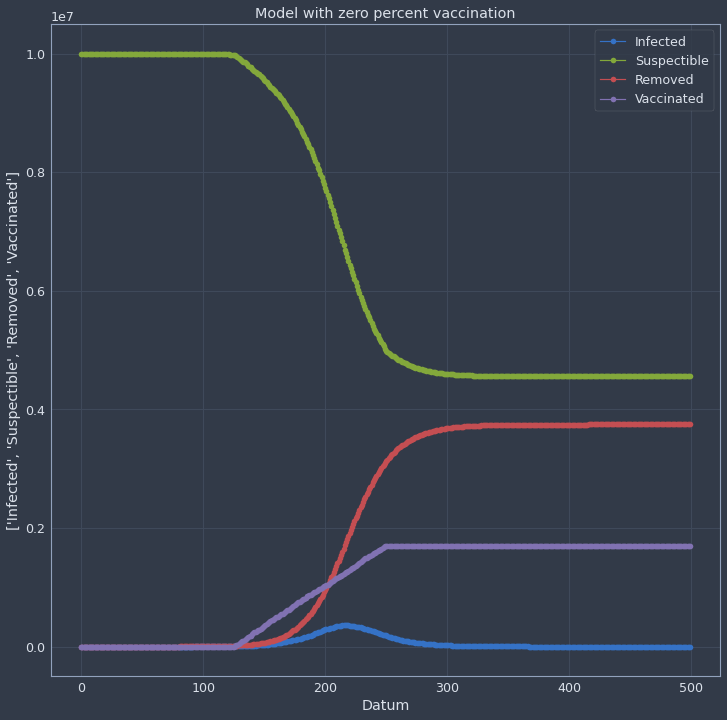

In [179]:
fig, ax = plt.subplots(figsize=(12, 12))
cplot(
    fig, ax, 
    model_SIR_with_vaccination(V_percentage=17.5),
    ['Infected', 'Suspectible', 'Removed', 'Vaccinated'],
    "Model with zero percent vaccination", bars=False)
plt.show()

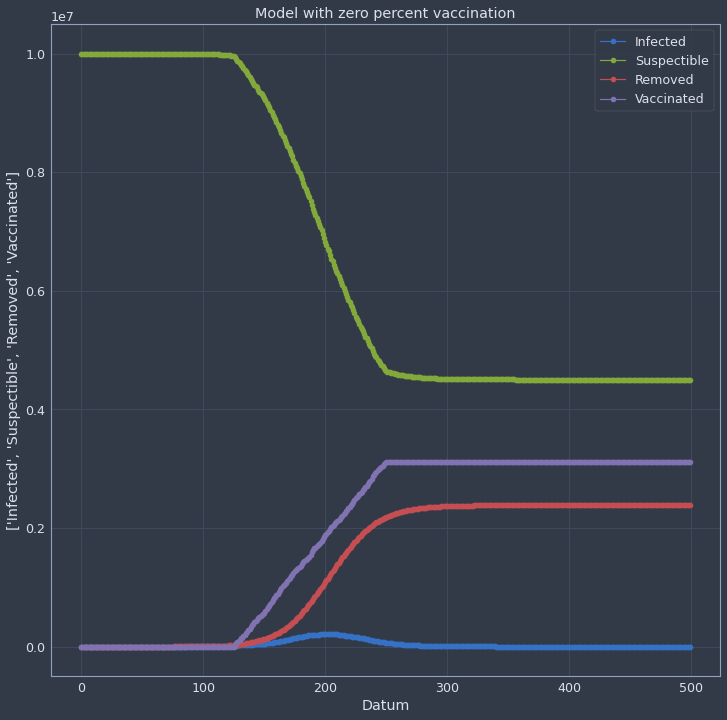

In [180]:
fig, ax = plt.subplots(figsize=(12, 12))
cplot(
    fig, ax, 
    model_SIR_with_vaccination(V_percentage=30.0),
    ['Infected', 'Suspectible', 'Removed', 'Vaccinated'],
    "Model with zero percent vaccination", bars=False)
plt.show()

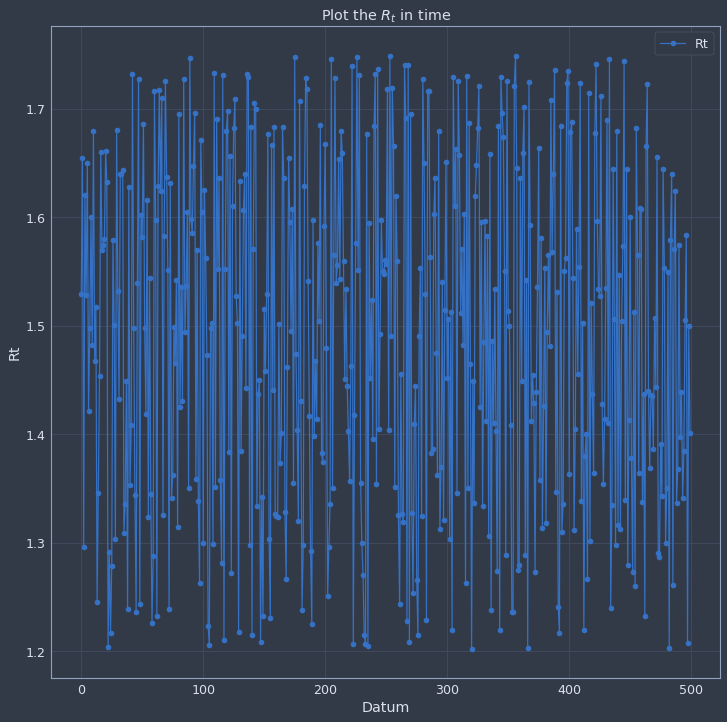

In [181]:
fig, ax = plt.subplots(figsize=(12, 12))
cplot(fig, ax, df, 'Rt', "Plot the $R_t$ in time", bars=False)
plt.show()

In [186]:
infection_CZ = pd.read_csv(
    'https://onemocneni-aktualne.mzcr.cz/api/v2/covid-19/kraj-okres-nakazeni-vyleceni-umrti.csv',
   parse_dates=['datum'], index_col=['datum']
    )
infection_PRG = infection_CZ.loc[infection_CZ['kraj_nuts_kod'] == 'CZ010']
infection_PRG['Infected'] = infection_PRG['kumulativni_pocet_nakazenych']-infection_PRG['kumulativni_pocet_vylecenych'] - infection_PRG['kumulativni_pocet_umrti']
infection_PRG.tail()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,kraj_nuts_kod,okres_lau_kod,kumulativni_pocet_nakazenych,kumulativni_pocet_vylecenych,kumulativni_pocet_umrti,Infected
datum,,,,,,
2020-10-15,CZ010,CZ0100,25893,14454,233,11206
2020-10-16,CZ010,CZ0100,27206,15006,244,11956
2020-10-17,CZ010,CZ0100,28358,15295,254,12809
2020-10-18,CZ010,CZ0100,28987,15693,259,13035
2020-10-19,CZ010,CZ0100,29983,16133,264,13586


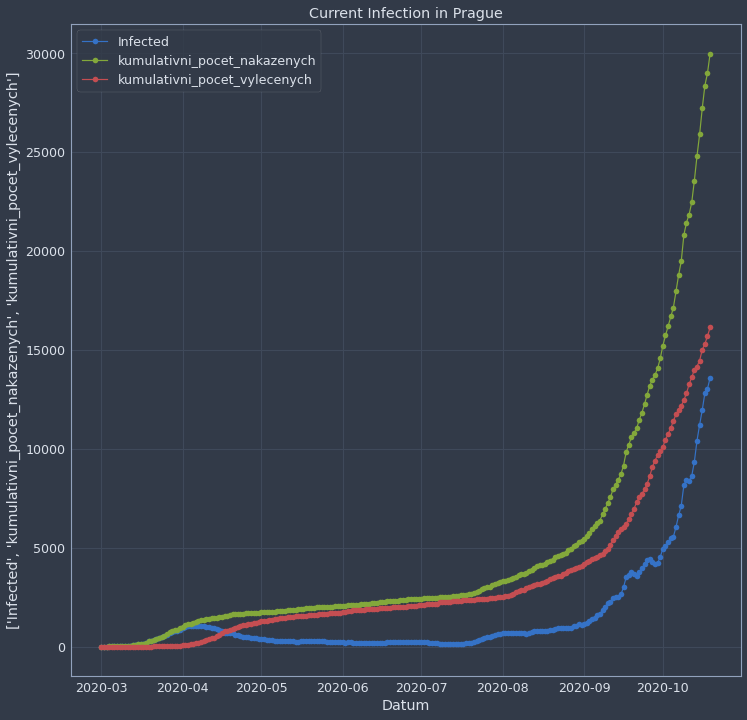

In [187]:
fig, ax = plt.subplots(figsize=(12, 12))
cplot(fig, ax, infection_PRG, ['Infected', 'kumulativni_pocet_nakazenych', 'kumulativni_pocet_vylecenych'], "Current Infection in Prague", bars=False)
plt.show()

In [224]:
regions = infection_CZ['okres_lau_kod'].unique()
data = {}
incidents = {}
for r in regions:
    data[r] = infection_CZ.loc[infection_CZ['okres_lau_kod'] == r]
    data[r]['daily'] = data[r]['kumulativni_pocet_nakazenych'] - data[r]['kumulativni_pocet_nakazenych'].shift(periods=1, fill_value=0)
    x = data[r]['daily'].floordiv(10.0)
    incidents[r] = x.to_numpy()
    

    
#data['CZ0100'].tail()
incidents

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


{'CZ0100': array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.,   0.,   1.,   3.,   2.,   2.,   3.,   7.,   3.,   6.,   2.,
          3.,   5.,   8.,   6.,  10.,   5.,   3.,   3.,   5.,   7.,   8.,
          6.,   2.,   3.,   3.,   3.,   5.,   4.,   3.,   1.,   1.,   1.,
          1.,   3.,   2.,   2.,   2.,   1.,   4.,   0.,   1.,   0.,   1.,
          1.,   0.,   0.,   1.,   1.,   2.,   1.,   0.,   0.,   0.,   1.,
          1.,   1.,   1.,   1.,   0.,   1.,   0.,   2.,   1.,   1.,   1.,
          1.,   2.,   1.,   1.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   0.,   0.,   1.,   1.,   2.,   1.,   0.,   0.,   0.,
          1.,   0.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   2.,
          2.,   0.,   0.,   0.,   1.,   1.,   1.,   1.,   1.,   0.,   0.,
          0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,
          0.,   0.,   1.,   1.,   1.,   2.,   1.,   1.,   2.,   2.,   6.,
          5.,   5.,   8.,   

In [228]:
#k = np.array(hundreds[150:])

def compute_likelihood_Rt(k, GAMMA=1.0/7.0):
    # We create an array for every possible value of Rt
    R_T_MAX = 12
    r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

    # Gamma is 1/serial interval
    # https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
    # https://www.nejm.org/doi/full/10.1056/NEJMoa2001316

    # Map Rt into lambda so we can substitute it into the equation below
    # Note that we have N-1 lambdas because on the first day of an outbreak
    # you do not know what to expect.
    lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

    # Evaluate the likelihood on each day and normalize sum of each day to 1.0
    likelihood_r_t = sps.poisson.pmf(k[1:], lam)
    likelihood_r_t /= np.sum(likelihood_r_t, axis=0)
    return likelihood_r_t
    
def compute_posteriors(likelihood_r_t):
    posteriors = likelihood_r_t.cumprod(axis=1)
    posteriors = posteriors / np.sum(posteriors, axis=0)


    columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')

    R_T_MAX = 12
    r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

    return pd.DataFrame(
        data = posteriors, #[:,30:31],
        index = r_t_range,
        columns = columns #[30:31]
    )


def compute_most_likely_values(posteriors):
    most_likely_values = posteriors.idxmax(axis=0)
    return most_likely_values

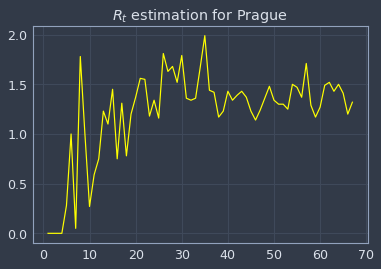

In [289]:
days_to_model = 68
#days_to_model = 80

incidents['CZ0100'][-days_to_model:]
r_t = compute_likelihood_Rt(incidents['CZ0100'][-days_to_model:], GAMMA=1/9.0)

#posteriors = r_t.cumprod(axis=1)
#posteriors = posteriors / np.sum(posteriors, axis=0)
p = compute_posteriors(r_t)
Rt = compute_most_likely_values(p)

plt.title("$R_t$ estimation for Prague")
plt.plot(Rt, color='yellow',)

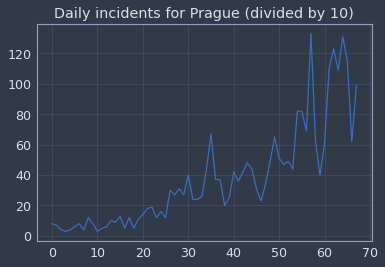

In [290]:
plt.title("Daily incidents for Prague (divided by 10)")
plt.plot(incidents['CZ0100'][-days_to_model:])

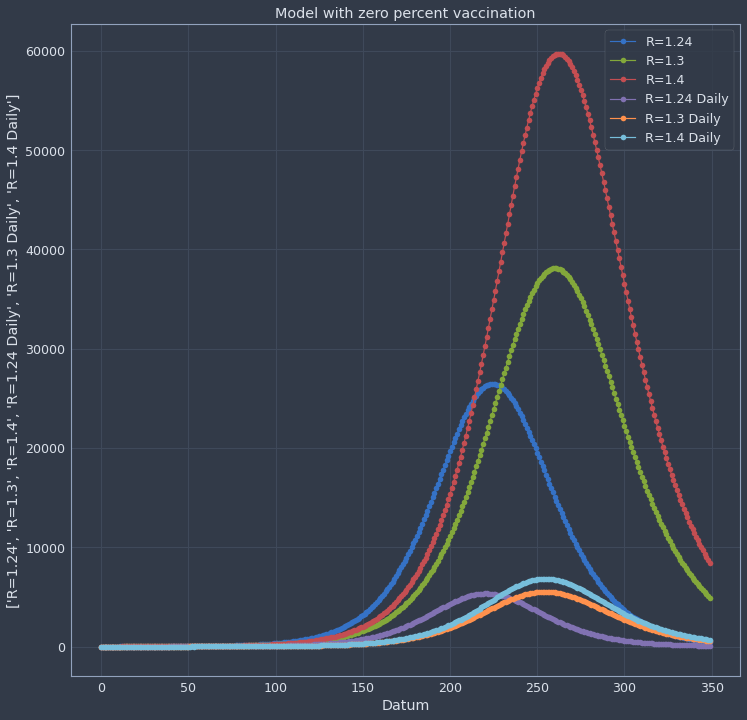

In [330]:

R = Rt[-40:].mean()
fig, ax = plt.subplots(figsize=(12, 12))

m1=model_SIR_with_vaccination(gamma=1.0/5.0, V_percentage=0, population=1300000, Rmin=1.24, Rmax=1.24, days_to_project=350)
m2=model_SIR_with_vaccination(gamma=1.0/7.0, V_percentage=0, population=1300000, Rmin=1.3, Rmax=1.3, days_to_project=350)
m3=model_SIR_with_vaccination(gamma=1.0/9.0, V_percentage=0, population=1300000, Rmin=1.4, Rmax=1.4, days_to_project=350)

df = pd.DataFrame(data={
    'R=1.24':m1['Infected'], 'R=1.3':m2['Infected'], 'R=1.4':m3['Infected'],
    'R=1.24 Daily':m1['Daily Cases'], 'R=1.3 Daily':m2['Daily Cases'], 'R=1.4 Daily':m3['Daily Cases']
})


cplot(
    fig, ax, 
    df,
    ['R=1.24', 'R=1.3', 'R=1.4', 'R=1.24 Daily', 'R=1.3 Daily', 'R=1.4 Daily'],
    "Model with zero percent vaccination", bars=False)
plt.show()


#f.head()

In [292]:
Rt[-40:].mean()

1.4055